In [2]:
from python_keras_semantic_segmentation.datasets.tfrecord import TFReader

record_dir = '/hdd/datasets/shapes/records/'
reader = TFReader(record_dir)

In [3]:
import tensorflow_addons as tfa
from tensorflow.keras.models import load_model
import os

log_dir = "/home/baudcode/Code/python-keras-semantic-segmentation/logs/shapes_logs_erfnet_128x128_bs_8_rgb_ranger_lr_1e-3"
model = load_model(os.path.join(log_dir, 'model-best.h5'), compile=False)
input_size = model.inputs[0].shape[1:3][::-1]
print("input size: ", input_size)

input size:  (128, 128)


In [4]:
from python_keras_semantic_segmentation.datasets import DataType
from python_keras_semantic_segmentation.processing.pre_dataset import get_preprocess_fn

test_ds = reader.get_dataset(DataType.TEST)
test_ds = test_ds.map(get_preprocess_fn(input_size))
test_ds = test_ds.batch(1)
print(test_ds)

2019-12-30 21:07:39,343 - DEBUG - TFReader found these (2) files: ['/hdd/datasets/shapes/records/test/data-0.tfrecord', '/hdd/datasets/shapes/records/test/data-1.tfrecord']


<BatchDataset shapes: ((None, 128, 128, None), (None, 128, 128, None)), types: (tf.float32, tf.float32)>


In [5]:
import tensorflow as tf

# get an example from the dataset
it = tf.compat.v1.data.make_one_shot_iterator(test_ds)
image_batch, mask_batch = next(it)

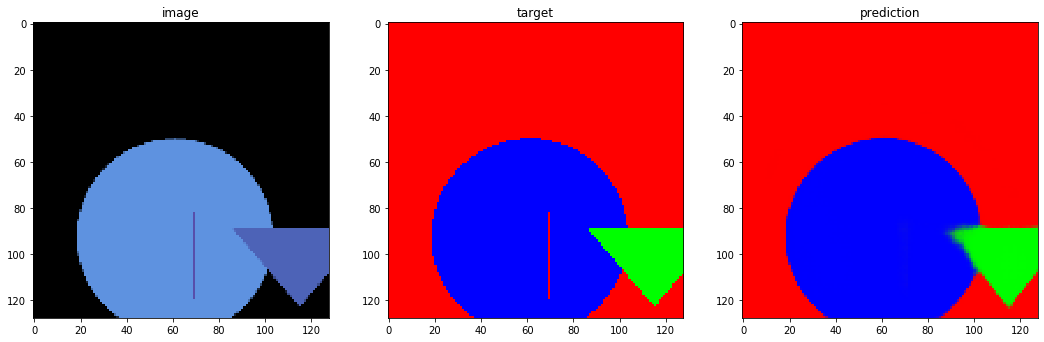

In [6]:
%matplotlib inline
from python_keras_semantic_segmentation.visualizations import show

# show predictions
predict_batch = model.predict_on_batch(image_batch)
show.show_images([image_batch[0], mask_batch[0], predict_batch[0]], titles=['image', 'target','prediction'])

# visualize classes
def draw_text_in_image(img, text, pos, color, line_width):
    font = cv2.FONT_HERSHEY_PLAIN
    fontScale = 1
    lineType = 1
    bottomLeftCornerOfText = pos
    cv2.putText(img, text,
            bottomLeftCornerOfText,
            font,
            fontScale,
            color,
            lineType)
    text_width, _ = cv2.getTextSize(text, font, fontScale, lineType)[0]
    return img, (line_width + text_width)


In [26]:
# !pip install sklearn
# print metrics
from python_keras_semantic_segmentation.eval import metrics
from python_keras_semantic_segmentation.losses import all as al
import numpy as np

# convert from eager tensor to numpy
if type(mask_batch) != np.ndarray:
    mask_batch = mask_batch.numpy()

print(mask_batch.shape)

mask_batch = mask_batch.round().astype(np.uint8)
predict_batch = predict_batch.round().astype(np.uint8)

print(predict_batch.max())

iou = metrics.iou_classwise(mask_batch, predict_batch, 3).tolist()
print("IOU (by class):", iou)
print("mIOU:", np.mean(iou))

print(al.iou_score(mask_batch.astype(np.float32), predict_batch.astype(np.float32)).numpy())
print(al.f_score(mask_batch.astype(np.float32), predict_batch.astype(np.float32)).numpy())
print(al.f_score(mask_batch.astype(np.float32), predict_batch.astype(np.float32), beta=2).numpy())
print(al.precision(mask_batch.astype(np.float32), predict_batch.astype(np.float32), beta=2).numpy())
print(al.recall(mask_batch.astype(np.float32), predict_batch.astype(np.float32), beta=2).numpy())

(1, 128, 128, 3)
1
IOU (by class): [0.9933394160583942, 0.9867200291067855, 0.0]
mIOU: 0.6600198150550599
0.97047997
0.9848585
0.9817309
0.9903582
0.9797149
